<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/multi_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
print(tf.__version__)

2.5.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

d21 = pd.read_csv('test_data_pca_dt_covid_fi.csv')
d20 = pd.read_csv('data_pca_dt_covid_fi.csv')
# 2019 - 2020
#d20 = d20.iloc[1461:,:]
d20 = d20.iloc[1826:,:]
d21_train = d21.iloc[:100,:]
d21_test = d21.iloc[100:,:]
df = pd.concat([d20,d21_train], ignore_index=True)

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

#Variables for training 
cols = list(df)[2:5]
df_for_training = df[cols].astype(float)

training_data = df_for_training.to_numpy()


trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
window_size = 7    # Number of past days we want to use to predict the future

for i in range(window_size, len(df_for_training) - n_future +1):
    trainX.append(training_data[i - window_size:i, :df_for_training.shape[1]])
    trainY.append(training_data[i + n_future - 1:i + n_future, :4])


trainX, trainY = np.array(trainX), np.array(trainY)
trainY = np.squeeze(trainY)

#trainX, trainY = shuffle(trainX, trainY, random_state=42)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (459, 7, 3).
trainY shape == (459, 3).


In [32]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, 
                         padding="causal", 
                         activation="relu", 
                         input_shape=(trainX.shape[1], trainX.shape[2])),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(512, return_sequences=False),
  tf.keras.layers.Dense(90, activation="relu"),
  #tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(trainY.shape[1]),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape"])

history = model.fit(trainX, trainY, epochs=65, batch_size=32,
                    validation_split=0.3, verbose=1,
                    callbacks=[lr_schedule])

Epoch 1/65
11/11 [==============================] - 3s 94ms/step - loss: 94.0558 - mae: 94.5557 - mape: 143.5899 - val_loss: 83.5637 - val_mae: 84.0637 - val_mape: 137.1172
Epoch 2/65
11/11 [==============================] - 0s 36ms/step - loss: 93.8464 - mae: 94.3462 - mape: 143.1889 - val_loss: 83.2560 - val_mae: 83.7560 - val_mape: 136.4784
Epoch 3/65
11/11 [==============================] - 0s 39ms/step - loss: 93.5292 - mae: 94.0289 - mape: 142.5731 - val_loss: 82.8636 - val_mae: 83.3636 - val_mape: 135.6684
Epoch 4/65
11/11 [==============================] - 0s 37ms/step - loss: 93.1483 - mae: 93.6480 - mape: 141.8409 - val_loss: 82.4109 - val_mae: 82.9109 - val_mape: 134.7303
Epoch 5/65
11/11 [==============================] - 0s 37ms/step - loss: 92.7157 - mae: 93.2154 - mape: 141.0306 - val_loss: 81.8964 - val_mae: 82.3964 - val_mape: 133.6640
Epoch 6/65
11/11 [==============================] - 0s 38ms/step - loss: 92.2219 - mae: 92.7218 - mape: 140.0789 - val_loss: 81.3068 - 

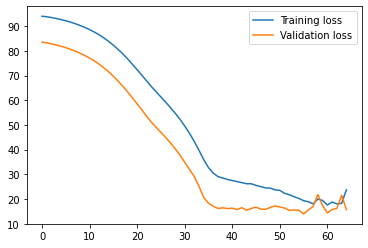

In [33]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [34]:
forecast_period = d21_test.shape[0]  
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=forecast_period, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #(1,31,10) shape of trainX[-n_future]
forecast

array([[25.851145, 80.49244 , 67.48827 ]], dtype=float32)

In [35]:
result = np.zeros((31, 3))
#result[0] = scaler.inverse_transform(forecast)[:,:4][0]
result[0] = [abs(int(i)) for i in forecast[:,:4][0]]
trainX[-1][-1][:3] = trainY[-1]

for i in range(30):
  y_pred_row = forecast
  row = list(y_pred_row[0])
  test = np.zeros((1, window_size, 3))
  test[0][:window_size - 1] = trainX[-1:][0][1:]
  test[0][window_size - 1] = row
  trainX = test
  forecast = model.predict(trainX)
  #print(forecast)
  #result[i] = scaler.inverse_transform(forecast)[:,:4][0]
  result[i+1] = [abs(int(i)) for i in forecast[:,:4][0]]

result

array([[ 25.,  80.,  67.],
       [ 21.,  78.,  58.],
       [ 26., 102.,  91.],
       [ 28.,  75.,  71.],
       [ 20.,  91.,  74.],
       [ 20.,  88.,  80.],
       [ 33.,  66.,  60.],
       [ 15.,  84.,  56.],
       [  9.,  77.,  65.],
       [ 15.,  86.,  76.],
       [ 14.,  84.,  62.],
       [ 11.,  87.,  70.],
       [ 10.,  83.,  67.],
       [ 20.,  77.,  57.],
       [ 11.,  89.,  57.],
       [  0.,  76.,  60.],
       [  6.,  80.,  60.],
       [ 11.,  85.,  57.],
       [  4.,  82.,  60.],
       [  4.,  72.,  54.],
       [ 15.,  89.,  48.],
       [ 12.,  86.,  37.],
       [  6.,  73.,  34.],
       [  1.,  70.,  42.],
       [  6.,  80.,  49.],
       [  2.,  70.,  48.],
       [  1.,  65.,  39.],
       [ 16.,  88.,  36.],
       [ 15.,  75.,  20.],
       [  7.,  53.,  19.],
       [  1.,  68.,  27.]])

In [36]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates[:31]), 
                            'chirurgie':result[:,0],
                            'medicale':result[:,1],
                            'orthopedie':result[:,2]})
                            #'flux_journalier':result.sum(axis=1)})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

cols = list(df)[:5]
original = df[cols]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-03-1']

#the real data that we predict
real = d21_test
real = real.iloc[:31,2:5].reset_index()

real.reset_index()
results = pd.concat([df_forecast, real], axis=1)
results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Date,chirurgie,medicale,orthopedie,index,CHIRURGIE,MEDICALE,ORTHOPEDIE
0,2021-04-10,25.0,80.0,67.0,100,27.0,39.0,87.0
1,2021-04-11,21.0,78.0,58.0,101,67.0,108.0,70.0
2,2021-04-12,26.0,102.0,91.0,102,51.0,69.0,61.0
3,2021-04-13,28.0,75.0,71.0,103,43.0,76.0,78.0
4,2021-04-14,20.0,91.0,74.0,104,40.0,87.0,77.0
5,2021-04-15,20.0,88.0,80.0,105,36.0,77.0,69.0
6,2021-04-16,33.0,66.0,60.0,106,42.0,92.0,43.0
7,2021-04-17,15.0,84.0,56.0,107,17.0,53.0,41.0
8,2021-04-18,9.0,77.0,65.0,108,46.0,88.0,60.0
9,2021-04-19,15.0,86.0,76.0,109,41.0,77.0,71.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


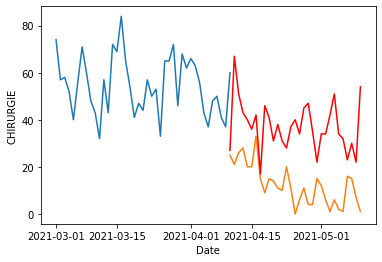

In [37]:
sns.lineplot(original['Date'], original['CHIRURGIE'])
sns.lineplot(df_forecast['Date'], df_forecast['chirurgie'])
sns.lineplot(df_forecast['Date'], real['CHIRURGIE'], color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


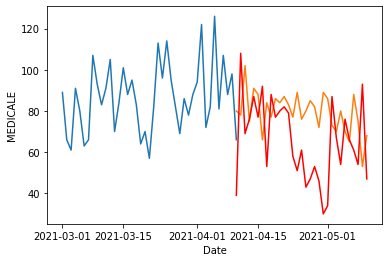

In [38]:
sns.lineplot(original['Date'], original['MEDICALE'])
sns.lineplot(df_forecast['Date'], df_forecast['medicale'])
sns.lineplot(df_forecast['Date'], real['MEDICALE'], color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


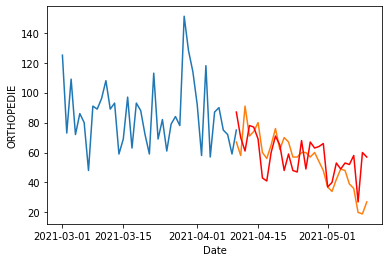

In [39]:
sns.lineplot(original['Date'], original['ORTHOPEDIE'])
sns.lineplot(df_forecast['Date'], df_forecast['orthopedie'])
sns.lineplot(df_forecast['Date'], real['ORTHOPEDIE'], color='r')